# Modeling the effects of artesunate on erythropoesis in malariainfection

erste Version ohne Immunsystem, Medikament, aber mit Erythropoese,Parasit

In [7]:
#packages
import pandas as pd
import seaborn as sns
import numpy as np
import tellurium as te
import matplotlib.pyplot as plt

## Data von Florian

In [8]:
# import data from florian
data_df = pd.read_csv('./PADH_sample_set.csv')
data_df = data_df[['Tag', 'OIE ‰', 'infected ‰', 'Hb (g/l)', 'Retis ‰']]

data_df.head()

,Tag,OIE ‰,infected ‰,Hb (g/l),Retis ‰
0,1.0,35.849057,391.644205,9.6,NaN
1,NaN,NaN,NaN,NaN,NaN
2,3.0,199.074074,87.268519,8.1,NaN
3,4.0,350.279330,0.000000,7.6,13.3
4,NaN,NaN,NaN,NaN,NaN


![model schmeme](schema_erythropoese_6.svg)


## Model

In [9]:
### Steady State

t_R_aging= 1          
t_E_death= 120 
Hkt      = 0.45
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_blood= 1e-6          # =1µl, in l, gesamtes Blutvolumen 

# E0
## E0 aus Hämatokrit-wert abgeleitet
##Hämatokrit Formel nach E umgestellt, 
##E0 = ((Hkt * Vol_blood) - (R0 * Vol_R))/Vol_E
## einfügen von R0, nach E0 umstellen

E0 = (Hkt * Vol_blood * (t_E_death/2))/ ( ((t_E_death/2)* Vol_E) + ((t_R_aging/2)*Vol_R))

R0   = E0 * t_R_aging/ t_E_death 

#P0  = (R0 * (k_R_death +k_R_aging))/ (2^10 * k_P_aging)   
P0  = (R0* (0.001 + (np.log(2) / (1/2))))/ ((2**10) *np.log(2) / (10/2))

print (E0, R0, P0, R0/E0, R0+E0)

#EPO flux
b   = 100
c   = 0.04
hemoglobin= 137.25001
EPO = 15
P   = P0
d = -np.log(0.5)/P
a = EPO * (1-np.exp(-d*P))*(1+np.exp((hemoglobin-b)*c))
J_EPO_prod = a/ (1+np.exp((hemoglobin-b)*c))
J_EPO_decay = EPO * (1-np.exp(-d*P))

#LDH
LDH = 180  #U/l
t_halb_LDH_decay= 4
J_E_death = 64312.62500040728
J_R_death = 46.39175257731957
LDH_decay=  LDH * np.log(2)/t_halb_LDH_decay
LDH_conc_E = (LDH_decay * Vol_blood) / (J_E_death* Vol_E +J_R_death * Vol_R)

print(f'E0:{E0} \nR0:{R0} \nP0:{P0} \na:{a}  \nd:{d} \nLDH_conc_E:{LDH_conc_E} ')

5567010.30927835 46391.75257731959 453.3712612598663 0.008333333333333333 5613402.06185567
40.77822970381671 0.001528873221107508


-4.999999999999998 3.25


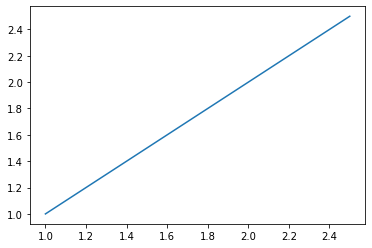

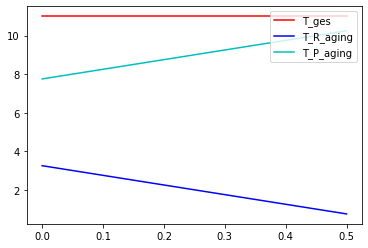

In [10]:
#RPI Zusammenhang Hamatokrit und Reifungstage von Retis in peripheren Blut (R) und Retis die in Knochenmark noch sind (Teil von P)
# https://www.labopart.de/einsender/formelberechnungen/rpi/
# s. Manuskript für Formel

HK = [0.15, 0.25, 0.35, 0.45] 
days_T_R_aging = [2.5, 2.0, 1.5, 1.0]
#lineare Regression for function:  y = m*x +b
m,b = np.polyfit(HK, days_T_R_aging, 1)
print(m,b)
plt.plot(days_T_R_aging, days_T_R_aging)
plt.show()


#x-values, and y Functions for R aging and T aging
Hkt = np.linspace(0, 0.5, 100)
T_P_aging = 5 * Hkt + 7.75
T_R_aging =-5 * Hkt + 3.25
T_ges     = T_P_aging + T_R_aging

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(Hkt,T_ges, 'r', label='T_ges')
plt.plot(Hkt,T_R_aging, 'b', label='T_R_aging')
plt.plot(Hkt,T_P_aging, 'c', label='T_P_aging')
plt.legend(loc='upper right')
plt.show()



In [24]:
OIE_model = """
#species initiation
EPO = 15       #in mU/mL , (Thi,2010) erreicht nach (El Hassan 1997)max. 1000 mU/mL (miliunits)
P   = 453.3712612598663    
R   = 46391.75257731959   #für SS berechnet
E   = 5567010.30927835      #cells, bezieht sich auf gesamtvolumen 1 mikroliter
niE = 0        #
iE  = 0        #in cells/(kg body weight*10^11)
diE = 0
OIE = 0        #once-infected Erys
M   = 1e3      #Merozoiten,(Austin, 1997) pro mikroliter (10^6 cells/ml => 10^3 cells/mikroliter)
A   = 0        #Antikörper
I   = 0        #Immun cells, bei Infektion 10^-2
LDH = 180      # U/l

#Reactions 
##erythropoisis
EPOprod:       -> EPO   ; J_EPO_prod             
EPOdecay:  EPO ->       ; J_EPO_decay
Pbirth:        -> P     ; J_P_birth
Pdeath:      P ->       ; J_P_death
Page:        P -> 1024R ; J_P_aging     # Vorläufer teilen sich ca. 10x -> 2**10
Rdeath:      R ->       ; J_R_death 
Raging:      R -> E     ; J_R_aging        
Edeath:      E ->       ; J_E_death       
##parasite lifecircle 
infect:    E+M -> iE    ; J_E_infect     
iEdeath:    iE ->       ; J_iE_death     
iErupture:  iE -> 16M   ; J_iE_rupture  #Tumwiine (2008)
Mdeath:      M ->       ; J_M_death
##Artesunate treatment
iE_ART:     iE -> diE   ; J_iE_ART     
diE_pitt:  diE -> oiE   ; J_diE_pitt 
diE_death: diE ->       ; J_diE_death 
oiEdeath:  oiE ->       ; J_oiE_death
##LDH, haptoglobin
LDHrelease:       -> LDH  ; J_LDH_release   
LDHdecay:     LDH ->      ; J_LDH_decay 

#parameter initiation
#Lebenszeiten t
##Erythropoese
t_P_aging   := 5 * Hkt + 7.75          #in days, Entwicklung von Stammzelle zum Retikulozyt dauert ca. 5-9 Tage, plus 3 Tage die er schon retikulozyte ist aber noch in Rückenmark
t_R_aging   :=-5 * Hkt + 3.25          #in days, Entwicklung R -> E dauert ca 4 Tage (3 tage knochenmark, 1 Tage im peripheren Blut)-> wir betrachten nur Retis in peripheren Blut, bei niedrigen Hkt verlassen Retis eher Knochenmark,  reifen länger im Blut
t_E_death   = 120       #in 1/days, 120 Tage E Lebensdauer s. Jorins Quellen
##Infection with parasite
t_iE_rupture= 4          #in days, dauert ca 4 Tage bis Ruptur, sinuskurvig (2010 Th)
##Artesunate treatment
t_diE_pitt  = 0.25       #in days, bei Medikamentengabe nach 8h Maximum an gepitteten RBCs
t_oiE_death = 10         #in days, Lebenspanne von 7-14 Tage(Fanello,2017), 7-21 (Arguin 2014) -> dort Verweise nachgehen
##LDH
t_halb_LDH_decay = 4            #(3-5 Tage), https://www.medicoconsult.de/ldh/



#random Zahlen
KI_P_death = 15          #EPO Wert bei gesunden Menschen
##Konstanten für EPO- GG
b = 100
c = 0.04
d = -log(0.5)/P
a = EPO * (1-exp(-d*P))*(1+exp((Hb-b)*c))


#Assignments
##Erythropoese
J_EPO_prod  := k_EPO_prod         # hier später Abhängigkeit von, oiE, diE, iE einfügen (Ma, 2019) vlt (Hassan 2009)
J_EPO_decay := EPO* k_EPO_decay
J_P_birth    = k_P_birth   
J_P_death   := P * k_P_death
J_P_aging   := P * k_P_aging
J_R_death   := R * k_R_death
J_R_aging   := R * k_R_aging
J_E_death   := E * k_E_death
##Infection with parasite
J_E_infect  := E*M* k_E_infect       # einbezug parasit?, E ersmal als Abhängigkeit ausgelassen da am Anfang E >> M -> mit Jorin absprechen+
J_iE_death  := iE * k_iE_death       #einbezug antibodies, spleen
J_iE_rupture:= iE * k_iE_rupture     #16-32M s.Cowman 2016, Anderson 1989, Diebner 2000
J_M_death   := M  * k_M_death
##Artesunate treatment
J_iE_ART    := iE  * k_iE_ART       #einbezug artesunat
J_diE_pitt  := diE * k_diE_pitt     #spleen
J_diE_death := diE * k_diE_death
J_oiE_death := oiE * k_oiE_death
##LDH
J_LDH_release := (LDH_conc_E/ Vol_blood)* (J_E_death*Vol_E + J_iE_death*Vol_E + J_iE_rupture*Vol_E + J_R_death*Vol_R) 
J_LDH_decay   := LDH * k_LDH_decay

#Raten
##Erythropoese
k_EPO_prod := a/(1+exp((Hb-b)*c) )    # in #cell/day
k_EPO_decay:= 1-exp(-P*d)             # in 1/days, (Ma, 2009)
k_P_birth   = P * (k_P_death + k_P_aging)
k_P_death  := 1/(1+ (EPO/KI_P_death))     #geraten, muss hoch sein, da wenn EPO da ist, dese so stark erringert wird dass Erythropoese verstrkt wird 
k_P_aging  := ln(2) / (t_P_aging/2)       #in 1/days
k_R_death   = 0.001                       #in 1/days,  geraten
k_R_aging  := ln(2) / (t_R_aging/2)       #in 1/days 
k_E_death  := ln(2) / (t_E_death/2)       #in 1/days       #verkürzung bei Infektion: k_E_alter; 0.15aus komischen paper 2022
##infection with parasit                       
k_E_infect  = 2e-6                      #in 1/mikroliter*day ((Austin, 1997)
k_iE_death  = 0                         #in 1/days, vereinfacht in Austin(1998)  (0.025  Ma 2019)
k_iE_rupture= 1             #ln(2) / (t_iE_rupture/2)    #in 1/days, Austin(1998)
k_M_death   = 48                          #48 in 1/days 2010 Thi (48)
##Artesunate treatment
k_iE_ART    = 0                           # 0.01  geschätzt ohne Medikament, , ART hat 1h Halbwertszeit (Tilley 2016)
k_diE_pitt  = ln(2) / (t_diE_pitt  /2)    # bei Medikamentengabe nach 8h Maximum an gepitteten RBCs
k_diE_death = 0.001
k_oiE_death = ln(2) / (t_oiE_death/2)     #in 1/days               
##LDH, haptoglobin
k_LDH_decay  = ln(2) / t_halb_LDH_decay
              
#Hämoglobin           
#(noch diE, niE Volumen, iE, Konzentrationen hinzufügen)
##Volumen
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_iE   = 80e-15         #in l,   Jorin
#Vol_diE = 80e-15         #auf gleiches Volumen wie iE geschätzt
Vol_oiE  = 50e-15         #in l, Jorin
Vol_blood= 1e-6           # =1µl, in l, gesamtes Blutvolumen 
##Hb Konzentrationen
Hb_conc_R    = 300        #in g/l (Piva,2014) 
Hb_conc_E    = 340        #in g/l,  =MCHC, https://www.ucsfhealth.org/medical-tests/rbc-indices    
Hb_conc_iE   = 177        #in g/l  (Hanssen,2012)
#Hb_conc_diE =
#Hb_conc_oiE = 
#Hämatokrit, Hämoglobinhttps://www.labopart.de/einsender/formelberechnungen/rpi/
Hkt      := (Vol_E * E + Vol_R * R + Vol_iE * iE) / Vol_blood                             #0.4 ~ 40 %, #hier fehlen noch MCHC von infected Zellen https://www.charite.de/fileadmin/user_upload/microsites/m_cc05/ilp/referenzdb/30451.htm    https://www.labor-und-diagnose-2020.de/k15.html
Hb       := (Vol_E * E * Hb_conc_E + Vol_R * R * Hb_conc_R +  Vol_iE * iE * Hb_conc_iE ) / Vol_blood     #in g/l      https://www.charite.de/fileadmin/user_upload/microsites/m_cc05/ilp/referenzdb/30459.htm
Hb_g_dl  := Hb/10

#LDH & Haptoglobin
LDH_conc_E =  6062.500000000001  #U/l  #https://www.ncbi.nlm.nih.gov/books/NBK557536/?report=printable

J_P_try := 0

#Parasitemie
p := iE / (E + R + iE + oiE + diE)  

#RPI
R_percent := 100* R/(R+E)
shift     := -5 * Hkt + 3.25  # in days
RPI       := R_percent * Hkt/ (shift * 0.45) 
      
"""

## Simulation

In [25]:
OIE = te.loada(OIE_model)
#OIE.exportToSBML('./OIE.xml')

5567010.30927835
2.126705285177594


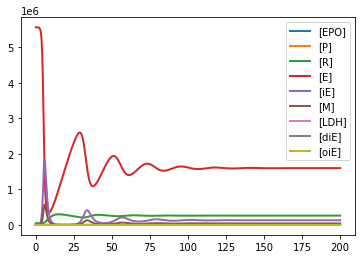

0.0


In [68]:
OIE = te.loada(OIE_model)
print(OIE.iE+ OIE.E)
#OIE.setValue("E", 2*10**6) 
result = OIE.simulate (0, 200, 1000)
print(OIE.RPI)
OIE.plot(result)
print(OIE.diE)


1000.0


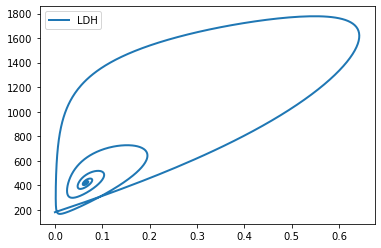

(420.6464931905747, 0.06594098886118702)

In [64]:
OIE = te.loada(OIE_model)
#OIE.setValue("k_E_infect",  1e-6) 
#OIE.setValue("k_iE_death", 0.01) 
print(OIE.M)

result = OIE.simulate (0, 300,5000, ['p', "LDH"])
OIE.plot(result)

OIE.LDH, OIE.p

0.0


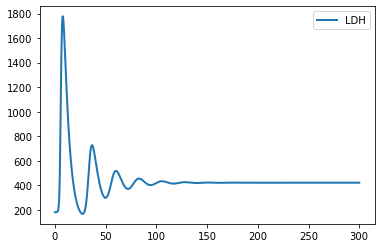

5.325557581172065

In [31]:
OIE = te.loada(OIE_model)
print(OIE.iE)
#OIE.setValue("E", 9*10**6) 
result = OIE.simulate (0, 300 ,1000,['time', 'LDH'])
OIE.plot(result)

OIE.Hb_g_dl

0.0


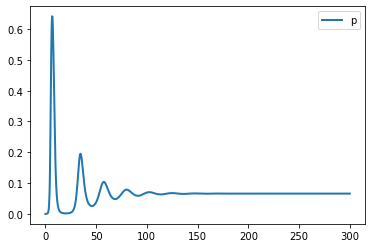

5.325557581172065

In [58]:
OIE = te.loada(OIE_model)
print(OIE.iE)
#OIE.setValue("E", 9*10**6) 
result = OIE.simulate (0, 300 ,1000,['time', 'p'])
OIE.plot(result)

OIE.Hb_g_dl

## Delay einbauen

In [16]:
s = ''.join([f'R{i}: S{i} -> S{i+1}; k_age\n' for i in range(10)])
print(s)

R0: S0 -> S1; k_age
R1: S1 -> S2; k_age
R2: S2 -> S3; k_age
R3: S3 -> S4; k_age
R4: S4 -> S5; k_age
R5: S5 -> S6; k_age
R6: S6 -> S7; k_age
R7: S7 -> S8; k_age
R8: S8 -> S9; k_age
R9: S9 -> S10; k_age



In [65]:
aging_R = ''.join([f'R{i}: S{i} -> S{i+1}; k_age * S{i}\n' for i in range(3)])
aging_E = ''.join([f'R{i}: S{i} -> S{i+1}; k_age\n' for i in range(3, 6)])
                  

model = """
balh;
{a_R}
blub;
{a_E}
""".format(a_R=aging_R, a_E=aging_E)

print(model)


balh;
R0: S0 -> S1; k_age * S0
R1: S1 -> S2; k_age * S1
R2: S2 -> S3; k_age * S2

blub;
R3: S3 -> S4; k_age
R4: S4 -> S5; k_age
R5: S5 -> S6; k_age




## Parameter Scanning

### small parameter scanning

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = []

readout = {
    "steady_state": lambda t,x:x[-1],
    #"max": lambda t,x: np.max(x),
    #"t_max": lambda t,x: t[np.argmax(x)]
}

para = 'k_E_infect'
fluxes = ['J_E_infect', 'J_iE_death', 'J_iE_rupture', 'J_M_death']

for i in np.logspace(-2,2,100):
    OIE = te.loada(OIE_model)
    p_value = i*OIE.getValue(para)
    OIE.setValue(para, p_value) 
    result = OIE.simulate (0, 10000, 1000, ["time",'M'])
    for k,v in readout.items():
        df.append({"p_name":para,"p_value":p_value,"i":i,"readout":k,"value":v(np.array(result[:,0]),np.array(result[:,1])),"species":'OIE.M'})

df = pd.DataFrame(df)

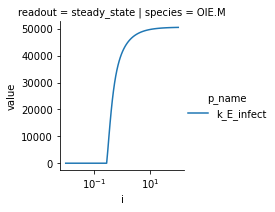

In [67]:
#filter_df = lambda df:df.loc[df["p_name"].isin(['k_E_infect', 'k_iE_rupture','k_iE_death'])]
filter_df = lambda df:df.loc[(df["p_name"].isin(['k_E_infect', 'k_M_death', 'k_iE_rupture','k_iE_death']))& (~df["species"].isin(["EPO", 'R', 'P', 'oiE', 'diE']))]

#g = sns.FacetGrid(data = df.loc[df["p_name"] == "k_E_infect"], col = "species",row = "readout", hue = "p_name", sharey=False)
g = sns.FacetGrid(data = filter_df(df), col = "species",row = "readout", hue = "p_name", sharey=False)
g.map_dataframe(sns.lineplot,"i","value").set(xscale = 'log')
g.add_legend()

### big parameter scanning

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = []

readout = {
    "steady_state": lambda t,x:x[-1],
    #"max": lambda t,x: np.max(x),
    #"t_max": lambda t,x: t[np.argmax(x)]
}

para = ['k_E_infect', 'k_M_death', 'k_iE_rupture','k_iE_death']
fluxes = ['J_E_infect', 'J_iE_death', 'J_iE_rupture', 'J_M_death']
outputlist = OIE.getFloatingSpeciesIds()+fluxes

OIE = te.loada(OIE_model)
for p_name in para:
#for p_name in OIE.getGlobalParameterIds()[0:5]:
    print(p_name)
    for i in np.logspace(-1,1,100):
        try:
            OIE = te.loada(OIE_model)
            p_value = i*OIE.getValue(p_name)
            OIE.setValue(p_name, p_value) 
            
        except Exception as e:continue
        result = OIE.simulate (0, 1000, 1000, ["time"] + outputlist)
        for o,species in enumerate(outputlist):
            for k,v in readout.items():
                df.append({"p_name":p_name,"p_value":p_value,"i":i,"readout":k,"value":v(np.array(result[:,0]),np.array(result[:,o+1])),"species":species})

df = pd.DataFrame(df)

In [ ]:
#filter_df = lambda df:df.loc[df["p_name"].isin(['k_E_infect', 'k_iE_rupture','k_iE_death'])]
filter_df = lambda df:df.loc[(df["p_name"].isin(['k_E_infect', 'k_M_death', 'k_iE_rupture','k_iE_death']))& (~df["species"].isin(["EPO", 'R', 'P', 'oiE', 'diE']))]

#g = sns.FacetGrid(data = df.loc[df["p_name"] == "k_E_infect"], col = "species",row = "readout", hue = "p_name", sharey=False)
g = sns.FacetGrid(data = filter_df(df), col = "species",row = "readout", hue = "p_name", sharey=False)
g.map_dataframe(sns.lineplot,"i","value").set(xscale = 'log')
g.add_legend()

In [ ]:
OIE = te.loada(OIE_model)
for x in OIE.__dir__():
    pass#print(x)

OIE.getFloatingSpeciesIds()

In [ ]:
OIE.selections

In [ ]:
#OIE.getSimulationData()